# Generative Adversarial Networks using TensorFlow and the MNIST Dataset

In [1]:
import numpy as np
import sys
import tensorflow as tf
import time

import load_mnist

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm

FLOAT = tf.float32

## Some Utility Functions

In [2]:
def Weight(shape, sd=0.02):
    initial = tf.random_normal(shape, mean=0, stddev=sd)
    return tf.Variable(initial, name="weights")

def Bias(shape, sd=0.02):
    initial = tf.random_normal(shape, mean=0, stddev=sd)
    return tf.Variable(initial, name="bias")

def StridedConv(x, W):
    return tf.nn.conv2d(
        x, W,
        strides=[1, 2, 2, 1],
        padding="SAME", name="strided_conv")

# The function tf.nn.deconv2d is an undecumented part of the TensorFlow API,
# and is pretty half baked. For instance, unlike just about every other similar
# function, deconv2d can't handle a batch size of -1. Even worse, instead of
# throwing a py Exception, it results in an uncaught C++ error that crashes the
# iPython kernel. And its signature or internals may unexpectedly change at any
# point in the future, since it's not a stable part of the API.
#
# Anyway, the crux of the matter is: it forces us to commit to a single batch
# size for the entire network architecture.

BATCH_SIZE = 100

def FractionallyStridedConv(x, W, output_channels=None, batch_size=BATCH_SIZE):
    _, height, width, kernels = x.get_shape().as_list()
    if output_channels is None:
        output_channels = kernels / 2
    return tf.nn.deconv2d(
        x, W,
        [batch_size, height * 2, width * 2, output_channels],
        [1, 2, 2, 1],
        name="fractionally_strided_conv")

# A batch norm that doesn't require running separate update ops!
# Stolen from http://stackoverflow.com/a/34634291
def BatchNorm(should_train, inp, scope="BatchNorm", affine=True):
    with tf.variable_scope(scope):
        beta = tf.Variable(
            tf.constant(0.0, shape=inp.get_shape()[-1:]),
            name="beta", trainable="true")
        gamma = tf.Variable(
            tf.constant(1.0, shape=inp.get_shape()[-1:]),
            name="gamma", trainable="true")
        batch_mean, batch_var = tf.nn.moments(inp, [0, 1, 2], name="moments")
        ema = tf.train.ExponentialMovingAverage(decay=0.9)
        ema_apply_op = ema.apply([batch_mean, batch_var])
        ema_mean = ema.average(batch_mean)
        ema_var = ema.average(batch_var)
        
        def MeanVarWithUpdate():
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)
            
        mean, var = tf.python.control_flow_ops.cond(
            should_train,
            MeanVarWithUpdate,
            lambda: (ema_mean, ema_var))

        return tf.nn.batch_norm_with_global_normalization(
            inp, mean, var, beta, gamma, 0.001, affine)

def LeakyReLUMaker(leak):
    def LeakyReLU(x):
        return tf.maximum(x, 0) + leak * tf.minimum(x, 0)
    return LeakyReLU

def ELU(x):
    pos = tf.cast(tf.greater_equal(x, 0), FLOAT)
    return (pos * x) + ((1 - pos) * (tf.exp(x) - 1))

## Generative Adversarial Networks
See Goodfellow et al (http://arxiv.org/pdf/1406.2661v1.pdf) for a description of GANs.

In essence, we pit two network against each other in a game. A discriminative network attempts to determine whether an input image belongs to the training distribution, or is a forgery. A generative network attempts to produce forgeries which fool the discriminative network.

See Radford, Metz, & Chintala (http://arxiv.org/pdf/1511.06434v1.pdf) for useful constraints on GAN architecture. The authors make the following recommendations:

- Use strided convolutions rather than max pooling.
- Use batchnorm everywhere other than generator output and discriminator input.
- No dense hidden layers.
- ReLU units in the generator (except output, which uses Tanh) and Leaky ReLU (with a leak of 0.2) in the discriminator.

I'll be using exponential liniar units (ELU) instead of ReLU / Leaky ReLU, and see if I can get away without batchnorm, as the ELU addresses some of the same issues: namely, encouraging inputs to each unit to approach 0, and allowing gradients to penetrate further into deep networks. Otherwise, I'll attempt to cleave to their suggestions.

The general architecture that Radford et al recommend for the generator is based on DCGAN. A vector of uniformly distributed noise is projected onto a small 2d image with a large number of channels. Repeated "fractionally strided convolutions" (sometimes erroneously called "deconvolutions", really the transpose of the convolution) successfively scale down the number of channels and scale up the size of the image.

They further recommend the following hyperparameters:
- Weights initialized with a 0-centered normal distribution having a std of 0.02
- Adam optimizer with a learning rate of 0.0002 and beta-1 of 0.5

In [3]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

no existing session to delete


#### Generative Network
The generative network maps a vector of uniform random noise inputs to a 28 x 28 1-channel image via a stack of three fractionally strided convolutional layers.

In [4]:
# G_nonlin = tf.nn.relu
G_nonlin = ELU

# Input a stack of 100-dimensional noise vectors.
# This spans the underlying object space of 10 digits.
G_x = tf.placeholder(FLOAT, [None, 100])

# Project noise into a 4x4 image with many channels.
# We won't update the weight that controls the projection during training.
with tf.name_scope("G_projection") as scope:
    G_W_proj = Weight([100, 4 * 4 * 256])
    G_b_proj = Bias([4 * 4 * 256])
    G_h_proj = tf.reshape(tf.matmul(G_x, G_W_proj) + G_b_proj, [-1, 4, 4, 256])

# Apply fractionally strided convolutions to decrease number of channels and increase image size.
with tf.name_scope("G_fsc1") as scope:
    G_W_fsc1 = Weight([2, 2, 128, 256])
    G_b_fsc1 = Bias([128])
    G_h_fsc1 = G_nonlin(FractionallyStridedConv(G_h_proj, G_W_fsc1) + G_b_fsc1)

with tf.name_scope("G_fsc2") as scope:
    G_W_fsc2 = Weight([2, 2, 64, 128])
    G_b_fsc2 = Bias([64])
    G_h_fsc2 = G_nonlin(FractionallyStridedConv(G_h_fsc1, G_W_fsc2) + G_b_fsc2)

with tf.name_scope("G_fsc3") as scope:
    G_W_fsc3 = Weight([2, 2, 1, 64])
    G_b_fsc3 = Bias([1])
    G_h_fsc3 = tf.nn.tanh(FractionallyStridedConv(G_h_fsc2, G_W_fsc3, output_channels=1) + G_b_fsc3)

# Trim output to 28x28 and put in the same scale as the source image
with tf.name_scope("G_out") as scope:
    G_y = tf.slice(G_h_fsc3, [0, 2, 2, 0], [-1, 28, 28, -1])
    G_image = tf.reshape((G_y + 1) * 127.5, [-1, 28, 28])

#### Discriminative Network

The discriminative network maps a 28 x 28 1-channel image to single float between 0 and 1, representing the probability that the image came from the training data distribution rather than the generative network.

The input of the discriminator is hooked up to the output of the generator. This lets us either train the discriminator, by ignoring the generator portion of the computation graph and providing input images in the feed dict, or the generator, by freezing the variables in the discriminator and feeding in noise.

In [5]:
# D_nonlin = LeakyReLUMaker(0.2)
D_nonlin = ELU

# Input is a stack of 28 x 28 black and white images with activations from 0 to 255.
D_x = G_y

# Target vector is a 1 (real) or 0 (forgery) for each input.
D_y_ = tf.placeholder(FLOAT, [None])

# Stack strided convolutional layers.
# Input should be 32x32, output 16x16
PADDING = [[0, 0], [2, 2], [2, 2], [0, 0]]
with tf.name_scope("D_sc1") as scope:
    D_W_conv1 = Weight([3, 3, 1, 16])
    D_b_conv1 = Bias([16])
    D_h_conv1 = D_nonlin(StridedConv(tf.pad(D_x, PADDING), D_W_conv1) + D_b_conv1)

# Input should be 16x16, output 8x8
with tf.name_scope("D_sc2") as scope:
    D_W_conv2 = Weight([3, 3, 16, 32])
    D_b_conv2 = Bias([32])
    D_h_conv2 = D_nonlin(StridedConv(D_h_conv1, D_W_conv2) + D_b_conv2)

# Input should be 8x8, output 4x4
with tf.name_scope("D_sc3") as scope:
    D_W_conv3 = Weight([3, 3, 32, 64])
    D_b_conv3 = Bias([64])
    D_h_conv3 = D_nonlin(StridedConv(D_h_conv2, D_W_conv3) + D_b_conv3)

# Output a single float between 0 and 1
with tf.name_scope("D_output") as scope:
    D_h_flat = tf.reshape(D_h_conv3, [-1, 4 * 4 * 64])
    D_W_out = Weight([4 * 4 * 64, 1])
    D_b_out = Bias([1])
    D_y = tf.nn.sigmoid(tf.matmul(D_h_flat, D_W_out) + D_b_out)

#### Adversarial Training

In [6]:
train_rate = tf.placeholder(FLOAT, [])

# Generator
# When we evaluate the generator training step, we feed noise into G_x.
# Never evaluate the generator train step when feeding real images into D_x.
# The outputs of D_y represent probability that the discriminator thinks
# generated images are real. So, we want to maximize some monotonically increasing
# function of D_y, ie minimize a monotonically decreasing function of D_y.

G_trainable_vars = [
    G_W_fsc1, G_b_fsc1,
    G_W_fsc2, G_b_fsc2,
    G_W_fsc3, G_b_fsc3]
G_err = -tf.reduce_mean(tf.log(D_y))
G_train_step = tf.train.AdamOptimizer(train_rate, beta1=0.5).minimize(
    G_err,
    var_list=G_trainable_vars)

# Discriminator
# When we evauate the descriminator train step, each minibatch should contain
# a mix of real and forged images, randomly shuffled, to prevent oscillation.
# We use cross entropy as our error metric.

D_trainable_vars = [
    D_W_conv1, D_b_conv1,
    D_W_conv2, D_b_conv2,
    D_W_conv3, D_b_conv3,
    D_W_out, D_b_out]
D_xent = -tf.reduce_mean(D_y_ * tf.log(D_y)) - tf.reduce_mean((1 - D_y_) * tf.log(1 - D_y))
D_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.greater_equal(D_y, 0.5), FLOAT), D_y_), FLOAT))
D_train_step = tf.train.AdamOptimizer(train_rate, beta1=0.5).minimize(
    D_xent,
    var_list=D_trainable_vars)

#### TensorBoard Annotations

In [7]:
hist_summaries = [
    tf.histogram_summary(var._variable.name, var)
    for var in G_trainable_vars + D_trainable_vars]

scalar_summaries = [
    tf.scalar_summary(name, var)
    for var, name in zip(
        (G_err, D_xent, D_accuracy),
        ("Generator Error", "Discriminator Cross-Entropy", "Discriminator Accuracy"))]

G_image_summary = tf.image_summary("Generator Output", G_y, max_images=10)

all_summaries = tf.merge_all_summaries()
writer = tf.train.SummaryWriter("/tmp/mnist_logs", sess.graph_def)

#### Fetch and read in data

In [8]:
try:
    (train_im, test_im, train_labels, test_labels)
except:
    train_im, test_im, train_labels, test_labels = load_mnist.Datasets()

#### Initialie vars

In [9]:
sess.run(tf.initialize_all_variables())

#### Main loop
For each minibatch:
1. Generate forgeries.
2. Train the discriminator on a mix of forgeries and real images.
3. Train the generator.

I've tried this with random normals, random uniforms from 0 to 1, and random uniforms from -1 to 1 as the input Z vectors. For some reason, for all but random uniforms -1 to 1, the generator produces nearly identical outputs for all inputs, and the network oscillates during training. In fact, training failed so completey that I thought I'd made a typo in the error function.

I'm stumped as for an explanation. Why is the shape and center of the noise distribution so important?

TODO: Look into it!

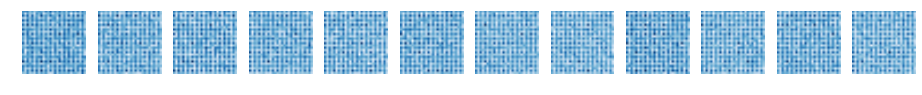

....................................................................................................
Epoch 0, batch 99 (51.1 seconds since last report)
DISCRIMINATOR: real 100% / 0.69227, forged 0% / 0.69414
GENERATOR: error = 0.69
....................................................................................................
Epoch 0, batch 199 (47.3 seconds since last report)
DISCRIMINATOR: real 96% / 0.69286, forged 0% / 0.69352
GENERATOR: error = 0.69
....................................................................................................
Epoch 0, batch 299 (48.2 seconds since last report)
DISCRIMINATOR: real 75% / 0.69309, forged 17% / 0.69328
GENERATOR: error = 0.69
....................................................................................................
Epoch 0, batch 399 (48.4 seconds since last report)
DISCRIMINATOR: real 60% / 0.69313, forged 16% / 0.69327
GENERATOR: error = 0.69
......................................................................

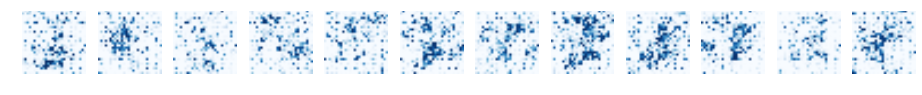

....................................................................................................
Epoch 1, batch 99 (50.4 seconds since last report)
DISCRIMINATOR: real 47% / 0.69320, forged 35% / 0.69321
GENERATOR: error = 0.69
....................................................................................................
Epoch 1, batch 199 (47.9 seconds since last report)
DISCRIMINATOR: real 57% / 0.69319, forged 23% / 0.69324
GENERATOR: error = 0.69
....................................................................................................
Epoch 1, batch 299 (52.4 seconds since last report)
DISCRIMINATOR: real 51% / 0.69321, forged 37% / 0.69321
GENERATOR: error = 0.69
....................................................................................................
Epoch 1, batch 399 (50.4 seconds since last report)
DISCRIMINATOR: real 19% / 0.69322, forged 67% / 0.69318
GENERATOR: error = 0.69
.....................................................................

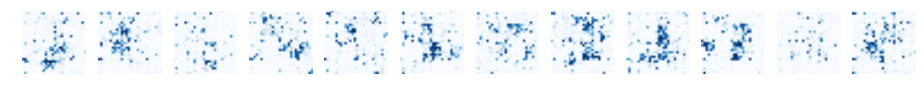

....................................................................................................
Epoch 2, batch 99 (49.8 seconds since last report)
DISCRIMINATOR: real 50% / 0.69321, forged 26% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 2, batch 199 (49.1 seconds since last report)
DISCRIMINATOR: real 50% / 0.69321, forged 31% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 2, batch 299 (51.0 seconds since last report)
DISCRIMINATOR: real 64% / 0.69319, forged 15% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 2, batch 399 (52.2 seconds since last report)
DISCRIMINATOR: real 95% / 0.69312, forged 1% / 0.69324
GENERATOR: error = 0.69
......................................................................

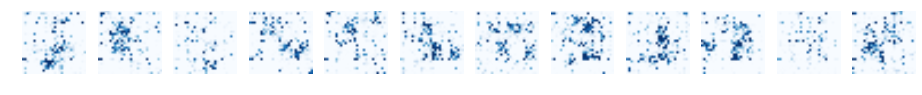

....................................................................................................
Epoch 3, batch 99 (60.6 seconds since last report)
DISCRIMINATOR: real 64% / 0.69320, forged 19% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 3, batch 199 (57.4 seconds since last report)
DISCRIMINATOR: real 76% / 0.69321, forged 13% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 3, batch 299 (50.7 seconds since last report)
DISCRIMINATOR: real 0% / 0.69328, forged 99% / 0.69301
GENERATOR: error = 0.69
....................................................................................................
Epoch 3, batch 399 (52.5 seconds since last report)
DISCRIMINATOR: real 0% / 0.69337, forged 100% / 0.69287
GENERATOR: error = 0.69
......................................................................

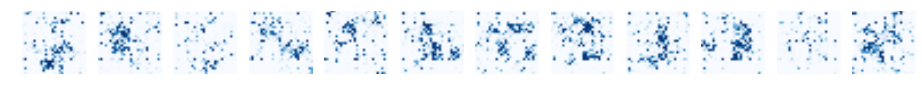

....................................................................................................
Epoch 4, batch 99 (48.9 seconds since last report)
DISCRIMINATOR: real 90% / 0.69322, forged 5% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 4, batch 199 (49.8 seconds since last report)
DISCRIMINATOR: real 94% / 0.69320, forged 1% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 4, batch 299 (57.1 seconds since last report)
DISCRIMINATOR: real 0% / 0.69328, forged 100% / 0.69301
GENERATOR: error = 0.69
....................................................................................................
Epoch 4, batch 399 (51.7 seconds since last report)
DISCRIMINATOR: real 0% / 0.69325, forged 100% / 0.69304
GENERATOR: error = 0.69
.......................................................................

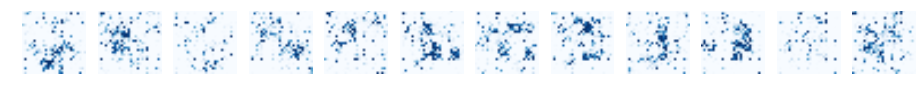

....................................................................................................
Epoch 5, batch 99 (54.2 seconds since last report)
DISCRIMINATOR: real 71% / 0.69322, forged 25% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 5, batch 199 (49.1 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 91% / 0.69321
GENERATOR: error = 0.69
....................................................................................................
Epoch 5, batch 299 (48.9 seconds since last report)
DISCRIMINATOR: real 0% / 0.69336, forged 100% / 0.69291
GENERATOR: error = 0.69
....................................................................................................
Epoch 5, batch 399 (51.0 seconds since last report)
DISCRIMINATOR: real 100% / 0.69290, forged 0% / 0.69336
GENERATOR: error = 0.69
......................................................................

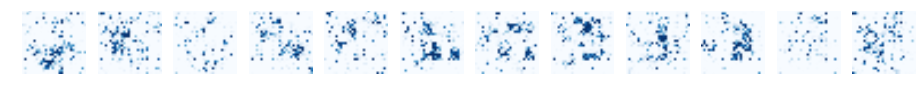

....................................................................................................
Epoch 6, batch 99 (55.3 seconds since last report)
DISCRIMINATOR: real 87% / 0.69322, forged 11% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 6, batch 199 (56.7 seconds since last report)
DISCRIMINATOR: real 100% / 0.69301, forged 0% / 0.69325
GENERATOR: error = 0.69
....................................................................................................
Epoch 6, batch 299 (53.6 seconds since last report)
DISCRIMINATOR: real 96% / 0.69319, forged 0% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 6, batch 399 (49.7 seconds since last report)
DISCRIMINATOR: real 90% / 0.69321, forged 5% / 0.69323
GENERATOR: error = 0.69
.......................................................................

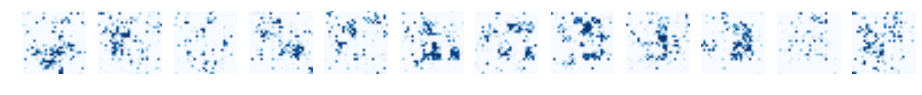

....................................................................................................
Epoch 7, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 36% / 0.69322, forged 51% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 7, batch 199 (43.3 seconds since last report)
DISCRIMINATOR: real 37% / 0.69322, forged 54% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 7, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 4% / 0.69322, forged 99% / 0.69321
GENERATOR: error = 0.69
....................................................................................................
Epoch 7, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 0% / 0.69324, forged 99% / 0.69314
GENERATOR: error = 0.69
.......................................................................

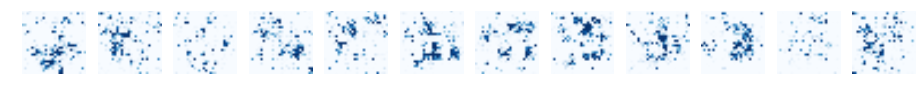

....................................................................................................
Epoch 8, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 61% / 0.69322, forged 30% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 8, batch 199 (42.0 seconds since last report)
DISCRIMINATOR: real 10% / 0.69322, forged 85% / 0.69321
GENERATOR: error = 0.69
....................................................................................................
Epoch 8, batch 299 (41.8 seconds since last report)
DISCRIMINATOR: real 100% / 0.69301, forged 0% / 0.69324
GENERATOR: error = 0.69
....................................................................................................
Epoch 8, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 95% / 0.69321, forged 1% / 0.69322
GENERATOR: error = 0.69
......................................................................

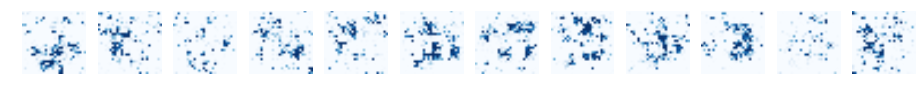

....................................................................................................
Epoch 9, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 96% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 9, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 3% / 0.69322, forged 100% / 0.69321
GENERATOR: error = 0.69
....................................................................................................
Epoch 9, batch 299 (42.5 seconds since last report)
DISCRIMINATOR: real 98% / 0.69321, forged 2% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 9, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 42% / 0.69322, forged 52% / 0.69322
GENERATOR: error = 0.69
.......................................................................

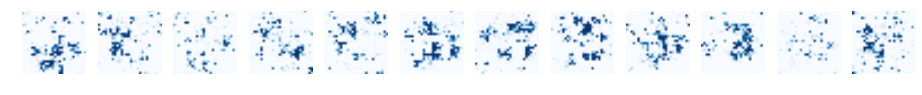

....................................................................................................
Epoch 10, batch 99 (42.8 seconds since last report)
DISCRIMINATOR: real 100% / 0.69314, forged 0% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 10, batch 199 (42.4 seconds since last report)
DISCRIMINATOR: real 97% / 0.69321, forged 1% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 10, batch 299 (42.1 seconds since last report)
DISCRIMINATOR: real 24% / 0.69322, forged 67% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 10, batch 399 (42.1 seconds since last report)
DISCRIMINATOR: real 0% / 0.69323, forged 100% / 0.69320
GENERATOR: error = 0.69
..................................................................

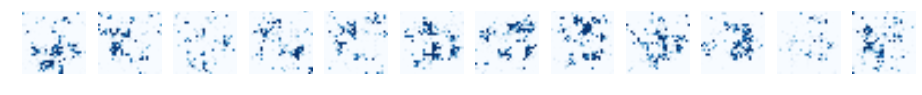

....................................................................................................
Epoch 11, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 4% / 0.69322, forged 91% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 11, batch 199 (42.1 seconds since last report)
DISCRIMINATOR: real 0% / 0.69327, forged 100% / 0.69301
GENERATOR: error = 0.69
....................................................................................................
Epoch 11, batch 299 (42.0 seconds since last report)
DISCRIMINATOR: real 0% / 0.69324, forged 100% / 0.69312
GENERATOR: error = 0.69
....................................................................................................
Epoch 11, batch 399 (43.0 seconds since last report)
DISCRIMINATOR: real 100% / 0.69303, forged 0% / 0.69324
GENERATOR: error = 0.69
..................................................................

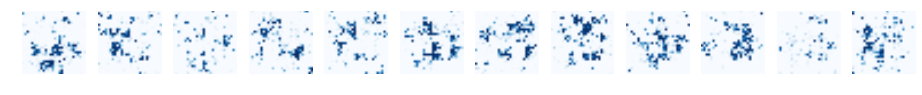

....................................................................................................
Epoch 12, batch 99 (42.5 seconds since last report)
DISCRIMINATOR: real 0% / 0.69324, forged 100% / 0.69301
GENERATOR: error = 0.69
....................................................................................................
Epoch 12, batch 199 (42.1 seconds since last report)
DISCRIMINATOR: real 0% / 0.69325, forged 100% / 0.69301
GENERATOR: error = 0.69
....................................................................................................
Epoch 12, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 0% / 0.69325, forged 100% / 0.69301
GENERATOR: error = 0.69
....................................................................................................
Epoch 12, batch 399 (43.5 seconds since last report)
DISCRIMINATOR: real 27% / 0.69322, forged 59% / 0.69322
GENERATOR: error = 0.69
.................................................................

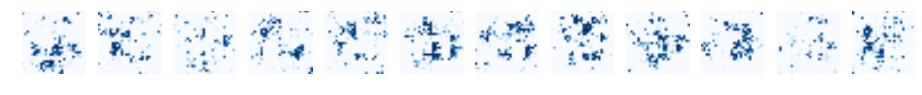

....................................................................................................
Epoch 13, batch 99 (43.8 seconds since last report)
DISCRIMINATOR: real 33% / 0.69322, forged 43% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 13, batch 199 (42.3 seconds since last report)
DISCRIMINATOR: real 100% / 0.69310, forged 0% / 0.69324
GENERATOR: error = 0.69
....................................................................................................
Epoch 13, batch 299 (42.2 seconds since last report)
DISCRIMINATOR: real 39% / 0.69322, forged 48% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 13, batch 399 (42.0 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 100% / 0.69322
GENERATOR: error = 0.69
.................................................................

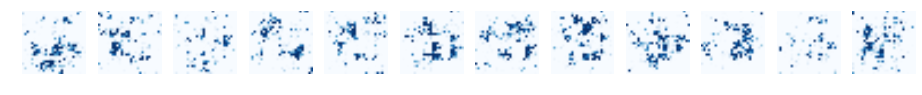

....................................................................................................
Epoch 14, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 0% / 0.69324, forged 100% / 0.69304
GENERATOR: error = 0.69
....................................................................................................
Epoch 14, batch 199 (42.0 seconds since last report)
DISCRIMINATOR: real 81% / 0.69322, forged 1% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 14, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 0% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 14, batch 399 (42.0 seconds since last report)
DISCRIMINATOR: real 100% / 0.69316, forged 0% / 0.69323
GENERATOR: error = 0.69
...................................................................

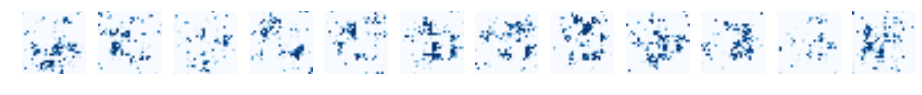

....................................................................................................
Epoch 15, batch 99 (42.9 seconds since last report)
DISCRIMINATOR: real 0% / 0.69323, forged 100% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 15, batch 199 (43.0 seconds since last report)
DISCRIMINATOR: real 100% / 0.69318, forged 0% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 15, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 42% / 0.69322, forged 47% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 15, batch 399 (42.2 seconds since last report)
DISCRIMINATOR: real 100% / 0.69316, forged 1% / 0.69323
GENERATOR: error = 0.69
.................................................................

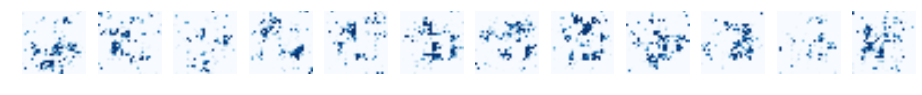

....................................................................................................
Epoch 16, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 99% / 0.69320, forged 0% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 16, batch 199 (42.1 seconds since last report)
DISCRIMINATOR: real 0% / 0.69324, forged 100% / 0.69310
GENERATOR: error = 0.69
....................................................................................................
Epoch 16, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 100% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 16, batch 399 (43.1 seconds since last report)
DISCRIMINATOR: real 0% / 0.69324, forged 100% / 0.69303
GENERATOR: error = 0.69
..................................................................

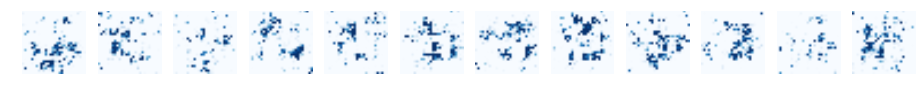

....................................................................................................
Epoch 17, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 100% / 0.69306, forged 0% / 0.69324
GENERATOR: error = 0.69
....................................................................................................
Epoch 17, batch 199 (41.9 seconds since last report)
DISCRIMINATOR: real 0% / 0.69323, forged 100% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 17, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 100% / 0.69321, forged 0% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 17, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 94% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
..................................................................

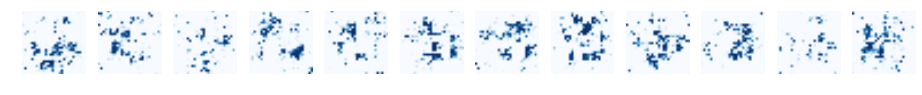

....................................................................................................
Epoch 18, batch 99 (43.2 seconds since last report)
DISCRIMINATOR: real 1% / 0.69322, forged 100% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 18, batch 199 (42.4 seconds since last report)
DISCRIMINATOR: real 0% / 0.69324, forged 100% / 0.69302
GENERATOR: error = 0.69
....................................................................................................
Epoch 18, batch 299 (42.2 seconds since last report)
DISCRIMINATOR: real 80% / 0.69322, forged 6% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 18, batch 399 (43.3 seconds since last report)
DISCRIMINATOR: real 0% / 0.69324, forged 100% / 0.69313
GENERATOR: error = 0.69
..................................................................

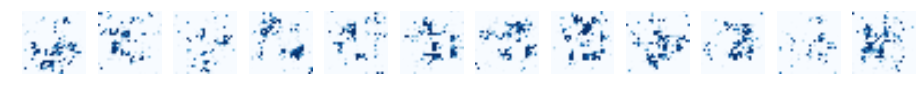

....................................................................................................
Epoch 19, batch 99 (42.5 seconds since last report)
DISCRIMINATOR: real 0% / 0.69325, forged 100% / 0.69301
GENERATOR: error = 0.69
....................................................................................................
Epoch 19, batch 199 (41.6 seconds since last report)
DISCRIMINATOR: real 100% / 0.69301, forged 0% / 0.69324
GENERATOR: error = 0.69
....................................................................................................
Epoch 19, batch 299 (42.0 seconds since last report)
DISCRIMINATOR: real 96% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 19, batch 399 (42.1 seconds since last report)
DISCRIMINATOR: real 56% / 0.69322, forged 24% / 0.69322
GENERATOR: error = 0.69
..................................................................

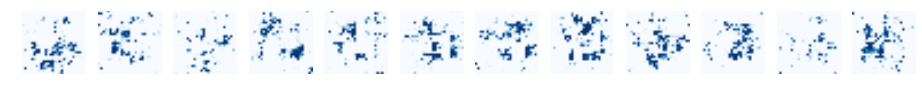

....................................................................................................
Epoch 20, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 1% / 0.69322, forged 99% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 20, batch 199 (41.8 seconds since last report)
DISCRIMINATOR: real 100% / 0.69317, forged 0% / 0.69324
GENERATOR: error = 0.69
....................................................................................................
Epoch 20, batch 299 (42.6 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 91% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 20, batch 399 (41.9 seconds since last report)
DISCRIMINATOR: real 59% / 0.69322, forged 29% / 0.69322
GENERATOR: error = 0.69
...................................................................

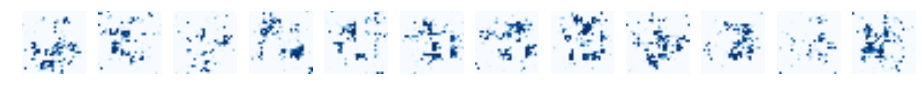

....................................................................................................
Epoch 21, batch 99 (42.8 seconds since last report)
DISCRIMINATOR: real 100% / 0.69310, forged 0% / 0.69324
GENERATOR: error = 0.69
....................................................................................................
Epoch 21, batch 199 (42.1 seconds since last report)
DISCRIMINATOR: real 98% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 21, batch 299 (42.0 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 97% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 21, batch 399 (42.0 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 100% / 0.69322
GENERATOR: error = 0.69
...................................................................

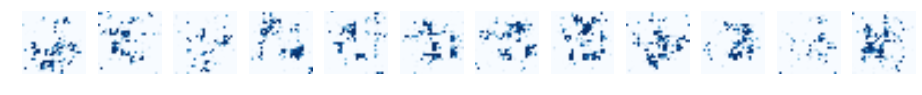

....................................................................................................
Epoch 22, batch 99 (42.9 seconds since last report)
DISCRIMINATOR: real 100% / 0.69316, forged 0% / 0.69324
GENERATOR: error = 0.69
....................................................................................................
Epoch 22, batch 199 (42.0 seconds since last report)
DISCRIMINATOR: real 85% / 0.69322, forged 7% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 22, batch 299 (41.8 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 1% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 22, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 5% / 0.69322, forged 82% / 0.69322
GENERATOR: error = 0.69
....................................................................

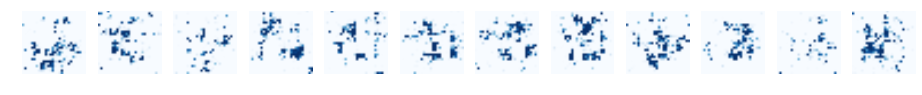

....................................................................................................
Epoch 23, batch 99 (42.9 seconds since last report)
DISCRIMINATOR: real 55% / 0.69322, forged 22% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 23, batch 199 (42.1 seconds since last report)
DISCRIMINATOR: real 5% / 0.69322, forged 89% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 23, batch 299 (42.2 seconds since last report)
DISCRIMINATOR: real 100% / 0.69322, forged 0% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 23, batch 399 (42.2 seconds since last report)
DISCRIMINATOR: real 99% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
...................................................................

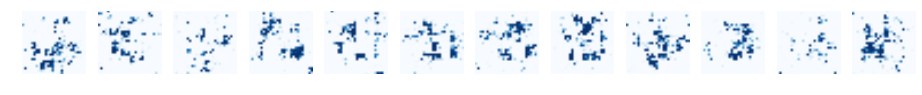

....................................................................................................
Epoch 24, batch 99 (42.8 seconds since last report)
DISCRIMINATOR: real 42% / 0.69322, forged 39% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 24, batch 199 (42.1 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 84% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 24, batch 299 (42.0 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 90% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 24, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 0% / 0.69323, forged 100% / 0.69322
GENERATOR: error = 0.69
...................................................................

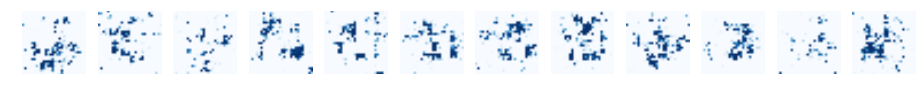

....................................................................................................
Epoch 25, batch 99 (44.1 seconds since last report)
DISCRIMINATOR: real 80% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 25, batch 199 (42.1 seconds since last report)
DISCRIMINATOR: real 22% / 0.69322, forged 50% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 25, batch 299 (42.1 seconds since last report)
DISCRIMINATOR: real 94% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 25, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 66% / 0.69322, forged 16% / 0.69322
GENERATOR: error = 0.69
..................................................................

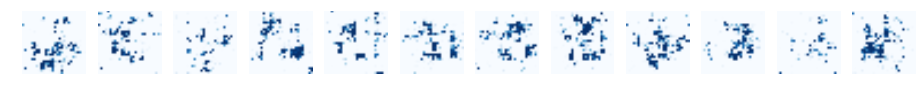

....................................................................................................
Epoch 26, batch 99 (43.0 seconds since last report)
DISCRIMINATOR: real 31% / 0.69322, forged 31% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 26, batch 199 (42.0 seconds since last report)
DISCRIMINATOR: real 100% / 0.69307, forged 0% / 0.69324
GENERATOR: error = 0.69
....................................................................................................
Epoch 26, batch 299 (42.2 seconds since last report)
DISCRIMINATOR: real 1% / 0.69322, forged 96% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 26, batch 399 (43.2 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 98% / 0.69322
GENERATOR: error = 0.69
...................................................................

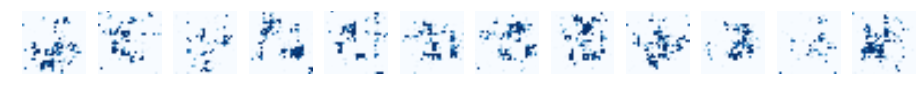

....................................................................................................
Epoch 27, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 1% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 27, batch 199 (41.8 seconds since last report)
DISCRIMINATOR: real 18% / 0.69322, forged 57% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 27, batch 299 (41.5 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 100% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 27, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 20% / 0.69322, forged 57% / 0.69322
GENERATOR: error = 0.69
..................................................................

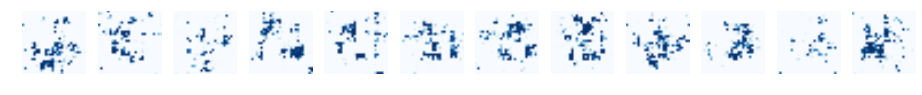

....................................................................................................
Epoch 28, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 75% / 0.69322, forged 14% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 28, batch 199 (41.8 seconds since last report)
DISCRIMINATOR: real 100% / 0.69322, forged 0% / 0.69323
GENERATOR: error = 0.69
....................................................................................................
Epoch 28, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 99% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 28, batch 399 (41.4 seconds since last report)
DISCRIMINATOR: real 3% / 0.69322, forged 88% / 0.69322
GENERATOR: error = 0.69
...................................................................

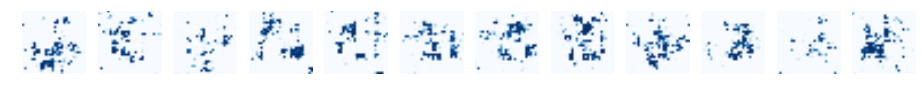

....................................................................................................
Epoch 29, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 98% / 0.69322, forged 1% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 29, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 24% / 0.69322, forged 47% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 29, batch 299 (41.8 seconds since last report)
DISCRIMINATOR: real 31% / 0.69322, forged 35% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 29, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 92% / 0.69322, forged 1% / 0.69322
GENERATOR: error = 0.69
...................................................................

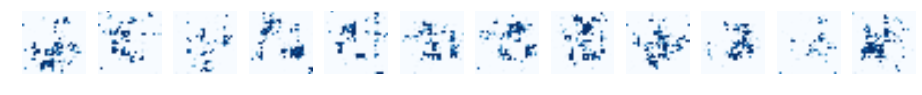

....................................................................................................
Epoch 30, batch 99 (42.9 seconds since last report)
DISCRIMINATOR: real 16% / 0.69322, forged 60% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 30, batch 199 (42.1 seconds since last report)
DISCRIMINATOR: real 92% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 30, batch 299 (42.0 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 98% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 30, batch 399 (42.0 seconds since last report)
DISCRIMINATOR: real 88% / 0.69322, forged 7% / 0.69322
GENERATOR: error = 0.69
....................................................................

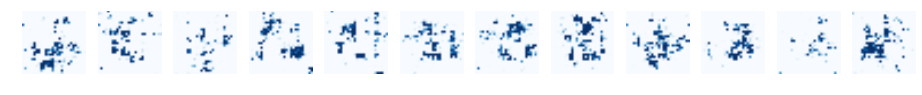

....................................................................................................
Epoch 31, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 79% / 0.69322, forged 5% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 31, batch 199 (41.6 seconds since last report)
DISCRIMINATOR: real 9% / 0.69322, forged 74% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 31, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 23% / 0.69322, forged 44% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 31, batch 399 (42.0 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
....................................................................

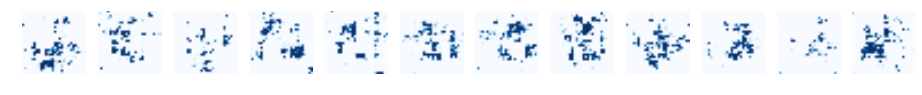

....................................................................................................
Epoch 32, batch 99 (43.0 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 97% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 32, batch 199 (41.9 seconds since last report)
DISCRIMINATOR: real 89% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 32, batch 299 (42.0 seconds since last report)
DISCRIMINATOR: real 4% / 0.69322, forged 86% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 32, batch 399 (41.9 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 67% / 0.69322
GENERATOR: error = 0.69
.....................................................................

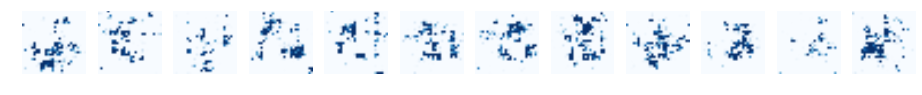

....................................................................................................
Epoch 33, batch 99 (43.8 seconds since last report)
DISCRIMINATOR: real 22% / 0.69322, forged 59% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 33, batch 199 (41.9 seconds since last report)
DISCRIMINATOR: real 100% / 0.69315, forged 0% / 0.69324
GENERATOR: error = 0.69
....................................................................................................
Epoch 33, batch 299 (42.0 seconds since last report)
DISCRIMINATOR: real 78% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 33, batch 399 (42.1 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
..................................................................

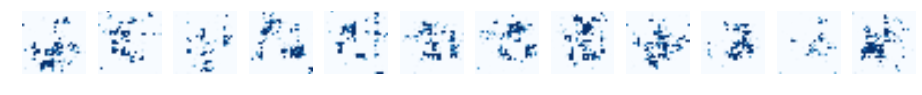

....................................................................................................
Epoch 34, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 85% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 34, batch 199 (41.9 seconds since last report)
DISCRIMINATOR: real 11% / 0.69322, forged 70% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 34, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 38% / 0.69322, forged 31% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 34, batch 399 (43.1 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 100% / 0.69322
GENERATOR: error = 0.69
..................................................................

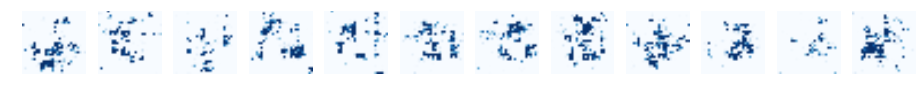

....................................................................................................
Epoch 35, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 17% / 0.69322, forged 53% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 35, batch 199 (42.0 seconds since last report)
DISCRIMINATOR: real 31% / 0.69322, forged 33% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 35, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 35, batch 399 (42.0 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 97% / 0.69322
GENERATOR: error = 0.69
...................................................................

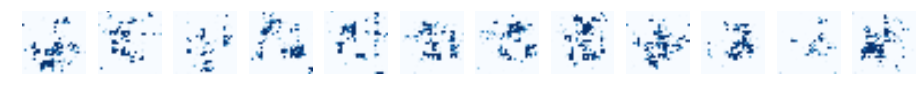

....................................................................................................
Epoch 36, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 1% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 36, batch 199 (41.9 seconds since last report)
DISCRIMINATOR: real 96% / 0.69322, forged 3% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 36, batch 299 (42.7 seconds since last report)
DISCRIMINATOR: real 86% / 0.69322, forged 6% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 36, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 26% / 0.69322, forged 41% / 0.69322
GENERATOR: error = 0.69
....................................................................

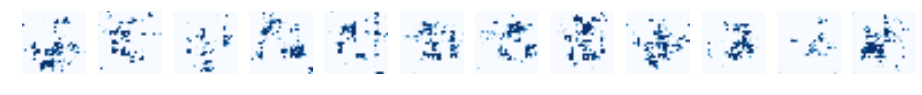

....................................................................................................
Epoch 37, batch 99 (42.5 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 95% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 37, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 88% / 0.69322, forged 3% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 37, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 30% / 0.69322, forged 36% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 37, batch 399 (42.0 seconds since last report)
DISCRIMINATOR: real 1% / 0.69322, forged 88% / 0.69322
GENERATOR: error = 0.69
....................................................................

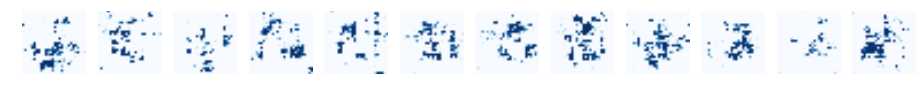

....................................................................................................
Epoch 38, batch 99 (42.9 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 38, batch 199 (42.3 seconds since last report)
DISCRIMINATOR: real 86% / 0.69322, forged 5% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 38, batch 299 (42.1 seconds since last report)
DISCRIMINATOR: real 96% / 0.69322, forged 3% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 38, batch 399 (42.9 seconds since last report)
DISCRIMINATOR: real 53% / 0.69322, forged 20% / 0.69322
GENERATOR: error = 0.69
....................................................................

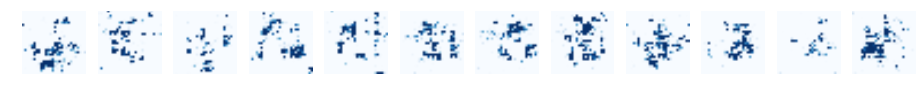

....................................................................................................
Epoch 39, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 96% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 39, batch 199 (41.8 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 2% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 39, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 65% / 0.69322, forged 6% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 39, batch 399 (41.9 seconds since last report)
DISCRIMINATOR: real 96% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
.....................................................................

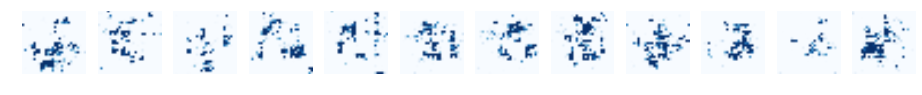

....................................................................................................
Epoch 40, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 30% / 0.69322, forged 33% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 40, batch 199 (41.9 seconds since last report)
DISCRIMINATOR: real 80% / 0.69322, forged 9% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 40, batch 299 (43.2 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 81% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 40, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 51% / 0.69322, forged 23% / 0.69322
GENERATOR: error = 0.69
...................................................................

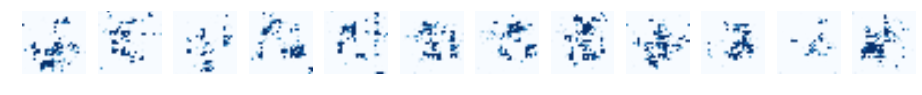

....................................................................................................
Epoch 41, batch 99 (42.5 seconds since last report)
DISCRIMINATOR: real 12% / 0.69322, forged 61% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 41, batch 199 (42.0 seconds since last report)
DISCRIMINATOR: real 87% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 41, batch 299 (42.1 seconds since last report)
DISCRIMINATOR: real 98% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 41, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 31% / 0.69322, forged 37% / 0.69322
GENERATOR: error = 0.69
...................................................................

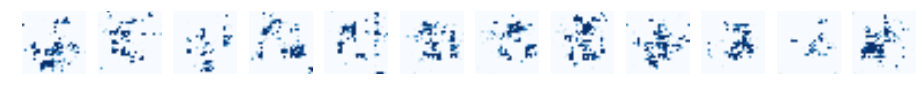

....................................................................................................
Epoch 42, batch 99 (44.1 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 69% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 42, batch 199 (42.4 seconds since last report)
DISCRIMINATOR: real 87% / 0.69322, forged 7% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 42, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 17% / 0.69322, forged 51% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 42, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 83% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................

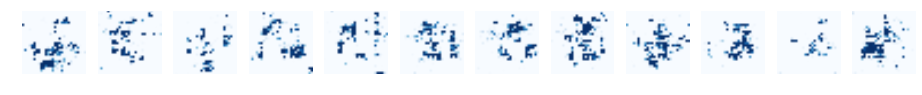

....................................................................................................
Epoch 43, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 27% / 0.69322, forged 38% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 43, batch 199 (41.8 seconds since last report)
DISCRIMINATOR: real 81% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 43, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 1% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 43, batch 399 (41.9 seconds since last report)
DISCRIMINATOR: real 30% / 0.69322, forged 35% / 0.69322
GENERATOR: error = 0.69
...................................................................

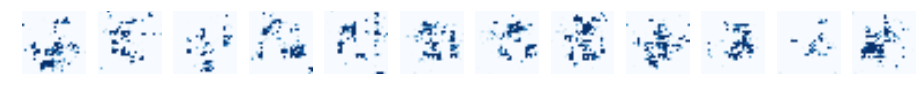

....................................................................................................
Epoch 44, batch 99 (42.8 seconds since last report)
DISCRIMINATOR: real 89% / 0.69322, forged 11% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 44, batch 199 (41.8 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 98% / 0.69321
GENERATOR: error = 0.69
....................................................................................................
Epoch 44, batch 299 (43.1 seconds since last report)
DISCRIMINATOR: real 91% / 0.69322, forged 1% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 44, batch 399 (42.0 seconds since last report)
DISCRIMINATOR: real 34% / 0.69322, forged 27% / 0.69322
GENERATOR: error = 0.69
...................................................................

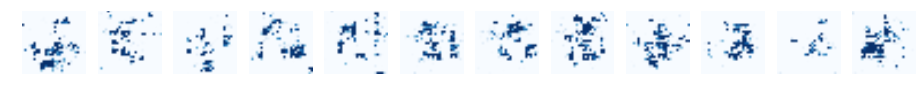

....................................................................................................
Epoch 45, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 0% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 45, batch 199 (41.6 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 78% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 45, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 35% / 0.69322, forged 25% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 45, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 97% / 0.69322, forged 1% / 0.69322
GENERATOR: error = 0.69
....................................................................

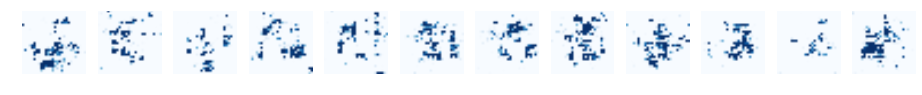

....................................................................................................
Epoch 46, batch 99 (42.5 seconds since last report)
DISCRIMINATOR: real 18% / 0.69322, forged 40% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 46, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 8% / 0.69322, forged 58% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 46, batch 299 (42.0 seconds since last report)
DISCRIMINATOR: real 46% / 0.69322, forged 16% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 46, batch 399 (42.9 seconds since last report)
DISCRIMINATOR: real 66% / 0.69322, forged 8% / 0.69322
GENERATOR: error = 0.69
...................................................................

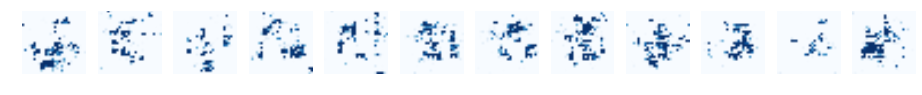

....................................................................................................
Epoch 47, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 25% / 0.69322, forged 38% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 47, batch 199 (41.9 seconds since last report)
DISCRIMINATOR: real 4% / 0.69322, forged 68% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 47, batch 299 (41.8 seconds since last report)
DISCRIMINATOR: real 85% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 47, batch 399 (41.9 seconds since last report)
DISCRIMINATOR: real 68% / 0.69322, forged 14% / 0.69322
GENERATOR: error = 0.69
...................................................................

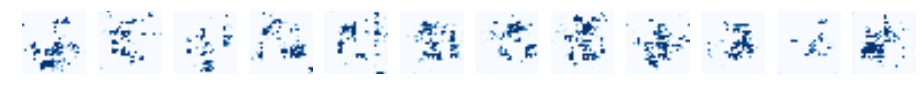

....................................................................................................
Epoch 48, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 92% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 48, batch 199 (42.7 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 100% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 48, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 61% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 48, batch 399 (42.0 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 77% / 0.69322
GENERATOR: error = 0.69
....................................................................

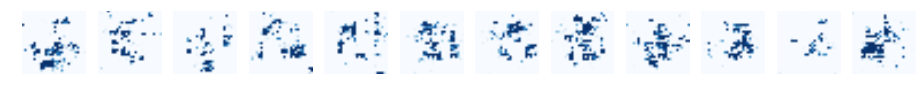

....................................................................................................
Epoch 49, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 77% / 0.69322, forged 7% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 49, batch 199 (42.2 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 89% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 49, batch 299 (42.2 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 79% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 49, batch 399 (43.1 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 95% / 0.69322
GENERATOR: error = 0.69
.....................................................................

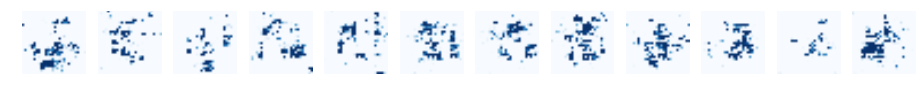

....................................................................................................
Epoch 50, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 60% / 0.69322, forged 19% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 50, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 68% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 50, batch 299 (41.5 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 74% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 50, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 58% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
...................................................................

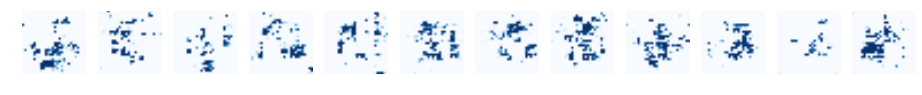

....................................................................................................
Epoch 51, batch 99 (43.2 seconds since last report)
DISCRIMINATOR: real 56% / 0.69322, forged 13% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 51, batch 199 (42.0 seconds since last report)
DISCRIMINATOR: real 92% / 0.69322, forged 3% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 51, batch 299 (43.0 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 81% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 51, batch 399 (43.0 seconds since last report)
DISCRIMINATOR: real 72% / 0.69322, forged 8% / 0.69322
GENERATOR: error = 0.69
....................................................................

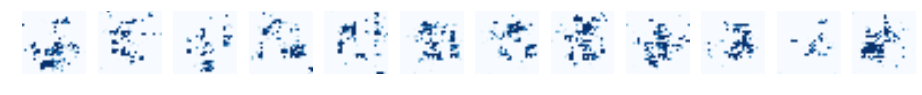

....................................................................................................
Epoch 52, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 1% / 0.69322, forged 72% / 0.69321
GENERATOR: error = 0.69
....................................................................................................
Epoch 52, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 85% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 52, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 15% / 0.69322, forged 41% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 52, batch 399 (41.6 seconds since last report)
DISCRIMINATOR: real 73% / 0.69322, forged 8% / 0.69322
GENERATOR: error = 0.69
....................................................................

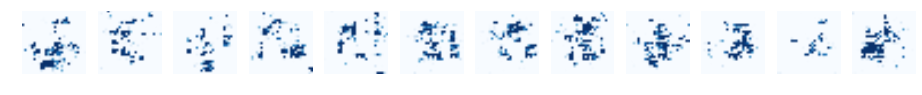

....................................................................................................
Epoch 53, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 91% / 0.69322, forged 3% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 53, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 89% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 53, batch 299 (41.8 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 72% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 53, batch 399 (42.8 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 74% / 0.69322
GENERATOR: error = 0.69
.....................................................................

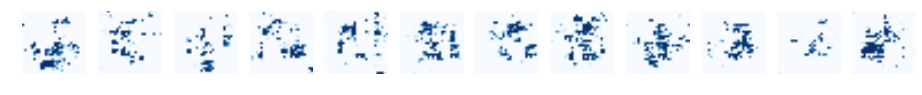

....................................................................................................
Epoch 54, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 63% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 54, batch 199 (41.6 seconds since last report)
DISCRIMINATOR: real 6% / 0.69322, forged 57% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 54, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 15% / 0.69322, forged 48% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 54, batch 399 (41.5 seconds since last report)
DISCRIMINATOR: real 60% / 0.69322, forged 12% / 0.69322
GENERATOR: error = 0.69
...................................................................

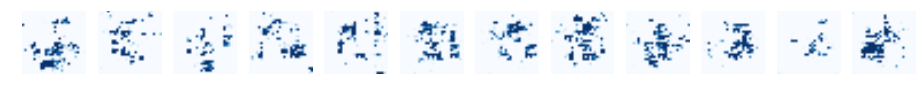

....................................................................................................
Epoch 55, batch 99 (43.5 seconds since last report)
DISCRIMINATOR: real 87% / 0.69322, forged 2% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 55, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 30% / 0.69322, forged 30% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 55, batch 299 (41.5 seconds since last report)
DISCRIMINATOR: real 72% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 55, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 92% / 0.69321
GENERATOR: error = 0.69
...................................................................

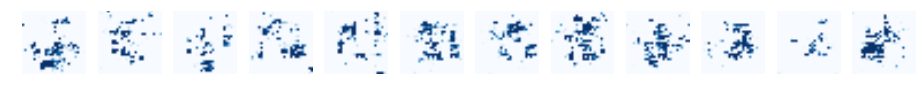

....................................................................................................
Epoch 56, batch 99 (42.3 seconds since last report)
DISCRIMINATOR: real 52% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 56, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 11% / 0.69322, forged 46% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 56, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 74% / 0.69322, forged 6% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 56, batch 399 (41.4 seconds since last report)
DISCRIMINATOR: real 4% / 0.69322, forged 49% / 0.69322
GENERATOR: error = 0.69
...................................................................

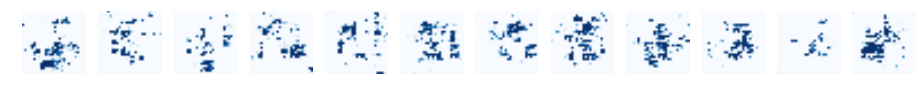

....................................................................................................
Epoch 57, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 16% / 0.69322, forged 33% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 57, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 30% / 0.69322, forged 29% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 57, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 15% / 0.69322, forged 29% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 57, batch 399 (41.9 seconds since last report)
DISCRIMINATOR: real 28% / 0.69322, forged 24% / 0.69322
GENERATOR: error = 0.69
.................................................................

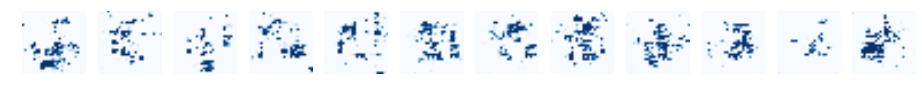

....................................................................................................
Epoch 58, batch 99 (42.2 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 90% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 58, batch 199 (41.9 seconds since last report)
DISCRIMINATOR: real 95% / 0.69322, forged 1% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 58, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 1% / 0.69322, forged 69% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 58, batch 399 (42.9 seconds since last report)
DISCRIMINATOR: real 80% / 0.69322, forged 7% / 0.69322
GENERATOR: error = 0.69
.....................................................................

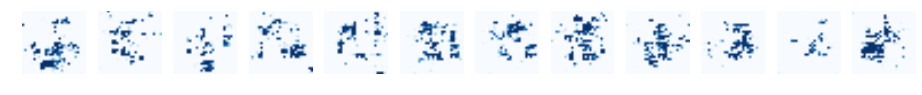

....................................................................................................
Epoch 59, batch 99 (42.5 seconds since last report)
DISCRIMINATOR: real 71% / 0.69322, forged 3% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 59, batch 199 (42.0 seconds since last report)
DISCRIMINATOR: real 69% / 0.69322, forged 14% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 59, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 69% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 59, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 54% / 0.69322
GENERATOR: error = 0.69
....................................................................

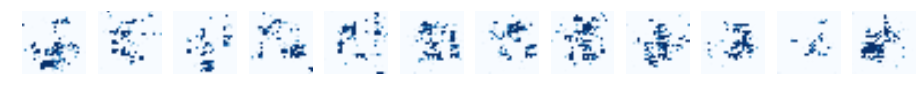

....................................................................................................
Epoch 60, batch 99 (43.6 seconds since last report)
DISCRIMINATOR: real 76% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 60, batch 199 (41.9 seconds since last report)
DISCRIMINATOR: real 24% / 0.69322, forged 34% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 60, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 41% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 60, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 93% / 0.69322
GENERATOR: error = 0.69
...................................................................

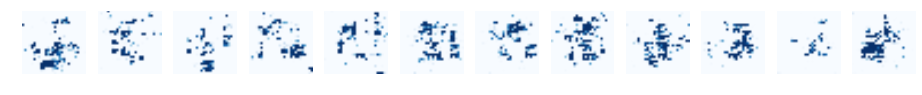

....................................................................................................
Epoch 61, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 58% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 61, batch 199 (41.6 seconds since last report)
DISCRIMINATOR: real 1% / 0.69322, forged 60% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 61, batch 299 (41.8 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 71% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 61, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 47% / 0.69322, forged 11% / 0.69322
GENERATOR: error = 0.69
....................................................................

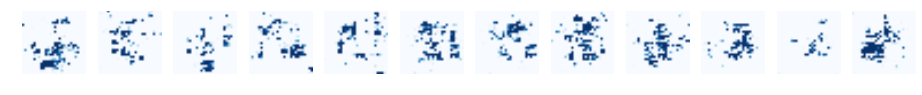

....................................................................................................
Epoch 62, batch 99 (42.9 seconds since last report)
DISCRIMINATOR: real 21% / 0.69322, forged 30% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 62, batch 199 (42.4 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 87% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 62, batch 299 (41.8 seconds since last report)
DISCRIMINATOR: real 28% / 0.69322, forged 34% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 62, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 3% / 0.69322, forged 62% / 0.69322
GENERATOR: error = 0.69
...................................................................

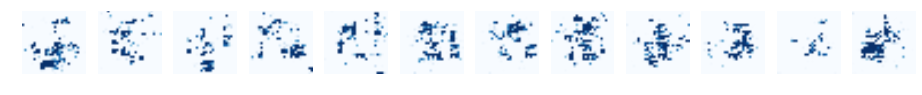

....................................................................................................
Epoch 63, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 55% / 0.69322, forged 17% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 63, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 5% / 0.69322, forged 43% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 63, batch 299 (41.8 seconds since last report)
DISCRIMINATOR: real 77% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 63, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 48% / 0.69322
GENERATOR: error = 0.69
....................................................................

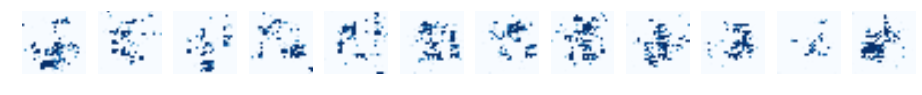

....................................................................................................
Epoch 64, batch 99 (42.5 seconds since last report)
DISCRIMINATOR: real 85% / 0.69322, forged 5% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 64, batch 199 (41.3 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 71% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 64, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 24% / 0.69322, forged 29% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 64, batch 399 (41.5 seconds since last report)
DISCRIMINATOR: real 15% / 0.69322, forged 34% / 0.69322
GENERATOR: error = 0.69
...................................................................

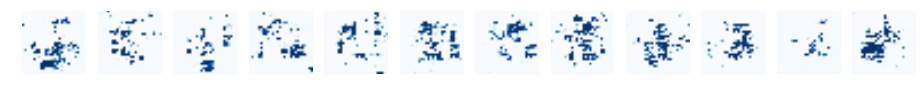

....................................................................................................
Epoch 65, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 59% / 0.69322, forged 15% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 65, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 58% / 0.69322, forged 5% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 65, batch 299 (43.1 seconds since last report)
DISCRIMINATOR: real 22% / 0.69322, forged 29% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 65, batch 399 (41.6 seconds since last report)
DISCRIMINATOR: real 31% / 0.69322, forged 19% / 0.69322
GENERATOR: error = 0.69
..................................................................

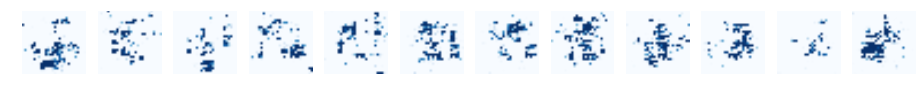

....................................................................................................
Epoch 66, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 74% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 66, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 28% / 0.69322, forged 20% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 66, batch 299 (41.8 seconds since last report)
DISCRIMINATOR: real 22% / 0.69322, forged 34% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 66, batch 399 (41.6 seconds since last report)
DISCRIMINATOR: real 10% / 0.69322, forged 46% / 0.69322
GENERATOR: error = 0.69
..................................................................

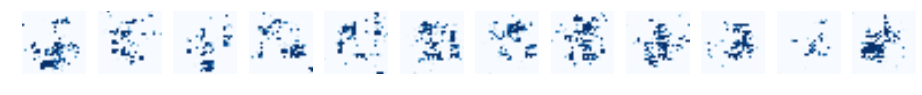

....................................................................................................
Epoch 67, batch 99 (43.5 seconds since last report)
DISCRIMINATOR: real 6% / 0.69322, forged 52% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 67, batch 199 (41.4 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 76% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 67, batch 299 (41.3 seconds since last report)
DISCRIMINATOR: real 77% / 0.69322, forged 8% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 67, batch 399 (41.4 seconds since last report)
DISCRIMINATOR: real 55% / 0.69322, forged 8% / 0.69322
GENERATOR: error = 0.69
.....................................................................

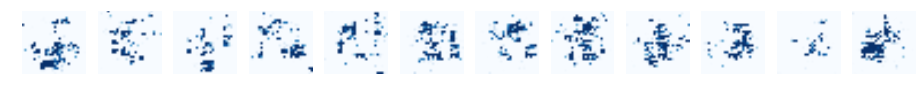

....................................................................................................
Epoch 68, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 45% / 0.69322, forged 20% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 68, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 20% / 0.69322, forged 18% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 68, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 55% / 0.69322, forged 13% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 68, batch 399 (41.4 seconds since last report)
DISCRIMINATOR: real 67% / 0.69322, forged 7% / 0.69322
GENERATOR: error = 0.69
..................................................................

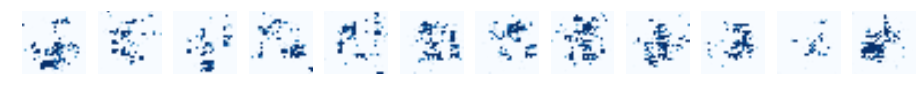

....................................................................................................
Epoch 69, batch 99 (42.2 seconds since last report)
DISCRIMINATOR: real 90% / 0.69322, forged 2% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 69, batch 199 (42.8 seconds since last report)
DISCRIMINATOR: real 82% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 69, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 1% / 0.69322, forged 52% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 69, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 29% / 0.69322, forged 23% / 0.69322
GENERATOR: error = 0.69
....................................................................

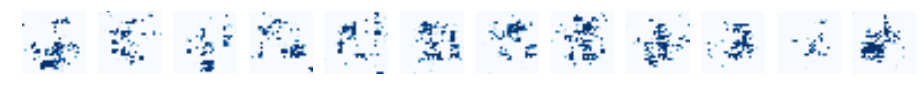

....................................................................................................
Epoch 70, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 37% / 0.69322, forged 19% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 70, batch 199 (41.6 seconds since last report)
DISCRIMINATOR: real 19% / 0.69322, forged 34% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 70, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 93% / 0.69322, forged 6% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 70, batch 399 (41.5 seconds since last report)
DISCRIMINATOR: real 40% / 0.69322, forged 22% / 0.69322
GENERATOR: error = 0.69
..................................................................

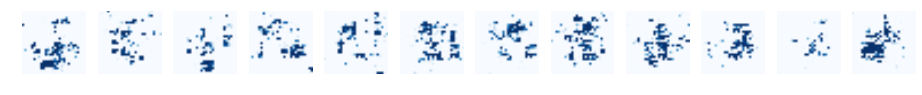

....................................................................................................
Epoch 71, batch 99 (42.3 seconds since last report)
DISCRIMINATOR: real 81% / 0.69322, forged 2% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 71, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 50% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 71, batch 299 (41.5 seconds since last report)
DISCRIMINATOR: real 46% / 0.69322, forged 15% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 71, batch 399 (41.5 seconds since last report)
DISCRIMINATOR: real 55% / 0.69322, forged 19% / 0.69322
GENERATOR: error = 0.69
..................................................................

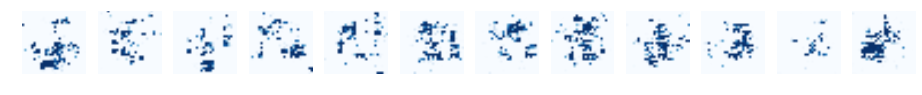

....................................................................................................
Epoch 72, batch 99 (43.3 seconds since last report)
DISCRIMINATOR: real 57% / 0.69322, forged 12% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 72, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 3% / 0.69322, forged 54% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 72, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 15% / 0.69322, forged 45% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 72, batch 399 (41.5 seconds since last report)
DISCRIMINATOR: real 21% / 0.69322, forged 29% / 0.69322
GENERATOR: error = 0.69
..................................................................

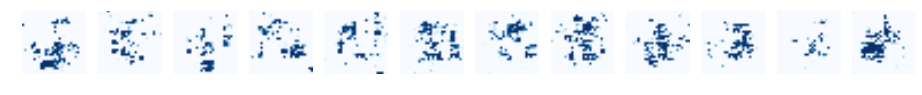

....................................................................................................
Epoch 73, batch 99 (42.5 seconds since last report)
DISCRIMINATOR: real 44% / 0.69322, forged 17% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 73, batch 199 (41.6 seconds since last report)
DISCRIMINATOR: real 14% / 0.69322, forged 37% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 73, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 6% / 0.69322, forged 48% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 73, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 6% / 0.69322, forged 51% / 0.69322
GENERATOR: error = 0.69
...................................................................

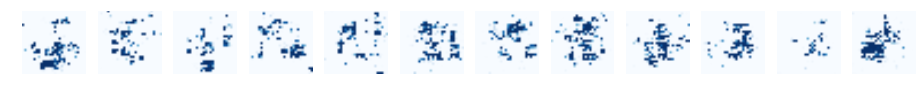

....................................................................................................
Epoch 74, batch 99 (42.5 seconds since last report)
DISCRIMINATOR: real 56% / 0.69322, forged 9% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 74, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 93% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 74, batch 299 (41.5 seconds since last report)
DISCRIMINATOR: real 35% / 0.69322, forged 20% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 74, batch 399 (41.5 seconds since last report)
DISCRIMINATOR: real 24% / 0.69322, forged 32% / 0.69322
GENERATOR: error = 0.69
...................................................................

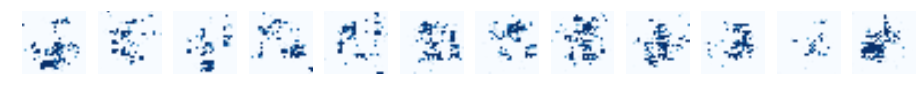

....................................................................................................
Epoch 75, batch 99 (43.0 seconds since last report)
DISCRIMINATOR: real 24% / 0.69322, forged 16% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 75, batch 199 (42.1 seconds since last report)
DISCRIMINATOR: real 56% / 0.69322, forged 11% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 75, batch 299 (42.5 seconds since last report)
DISCRIMINATOR: real 40% / 0.69322, forged 17% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 75, batch 399 (42.2 seconds since last report)
DISCRIMINATOR: real 17% / 0.69322, forged 33% / 0.69322
GENERATOR: error = 0.69
.................................................................

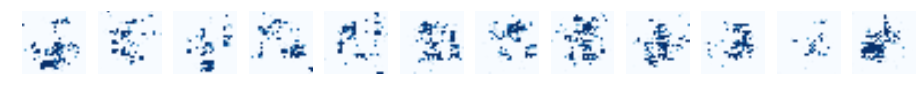

....................................................................................................
Epoch 76, batch 99 (42.3 seconds since last report)
DISCRIMINATOR: real 27% / 0.69322, forged 19% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 76, batch 199 (41.8 seconds since last report)
DISCRIMINATOR: real 44% / 0.69322, forged 12% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 76, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 4% / 0.69322, forged 57% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 76, batch 399 (41.6 seconds since last report)
DISCRIMINATOR: real 3% / 0.69322, forged 50% / 0.69322
GENERATOR: error = 0.69
...................................................................

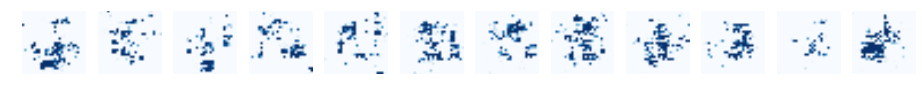

....................................................................................................
Epoch 77, batch 99 (42.2 seconds since last report)
DISCRIMINATOR: real 4% / 0.69322, forged 48% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 77, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 68% / 0.69322, forged 8% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 77, batch 299 (41.5 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 53% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 77, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 22% / 0.69322, forged 29% / 0.69322
GENERATOR: error = 0.69
....................................................................

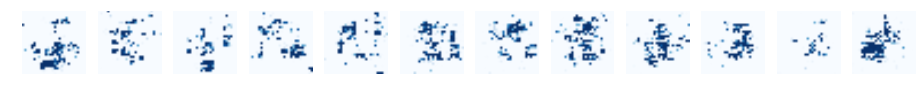

....................................................................................................
Epoch 78, batch 99 (42.3 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 70% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 78, batch 199 (42.7 seconds since last report)
DISCRIMINATOR: real 14% / 0.69322, forged 29% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 78, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 9% / 0.69322, forged 39% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 78, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 13% / 0.69322, forged 31% / 0.69322
GENERATOR: error = 0.69
...................................................................

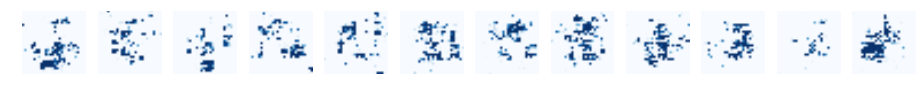

....................................................................................................
Epoch 79, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 5% / 0.69322, forged 56% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 79, batch 199 (41.4 seconds since last report)
DISCRIMINATOR: real 88% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 79, batch 299 (41.3 seconds since last report)
DISCRIMINATOR: real 12% / 0.69322, forged 34% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 79, batch 399 (41.4 seconds since last report)
DISCRIMINATOR: real 4% / 0.69322, forged 51% / 0.69322
GENERATOR: error = 0.69
....................................................................

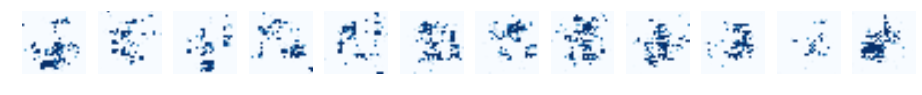

....................................................................................................
Epoch 80, batch 99 (43.4 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 61% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 80, batch 199 (41.2 seconds since last report)
DISCRIMINATOR: real 53% / 0.69322, forged 17% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 80, batch 299 (41.2 seconds since last report)
DISCRIMINATOR: real 24% / 0.69322, forged 31% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 80, batch 399 (41.4 seconds since last report)
DISCRIMINATOR: real 52% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
..................................................................

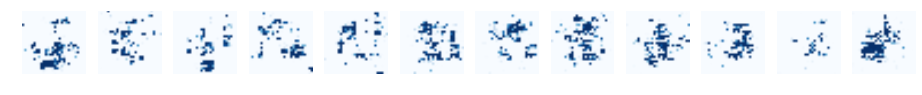

....................................................................................................
Epoch 81, batch 99 (42.3 seconds since last report)
DISCRIMINATOR: real 68% / 0.69322, forged 5% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 81, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 8% / 0.69322, forged 40% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 81, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 16% / 0.69322, forged 29% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 81, batch 399 (41.5 seconds since last report)
DISCRIMINATOR: real 42% / 0.69322, forged 14% / 0.69322
GENERATOR: error = 0.69
...................................................................

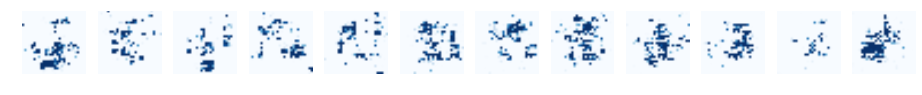

....................................................................................................
Epoch 82, batch 99 (42.3 seconds since last report)
DISCRIMINATOR: real 19% / 0.69322, forged 33% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 82, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 52% / 0.69322, forged 16% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 82, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 30% / 0.69322, forged 28% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 82, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 46% / 0.69322
GENERATOR: error = 0.69
..................................................................

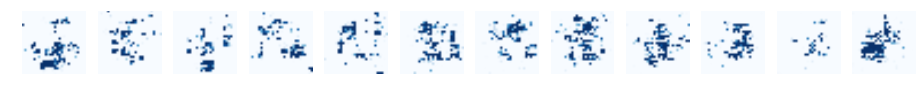

....................................................................................................
Epoch 83, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 17% / 0.69322, forged 35% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 83, batch 199 (41.4 seconds since last report)
DISCRIMINATOR: real 73% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 83, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 69% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 83, batch 399 (42.7 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 58% / 0.69322
GENERATOR: error = 0.69
...................................................................

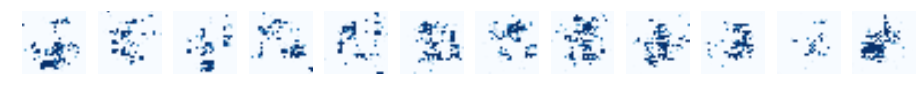

....................................................................................................
Epoch 84, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 72% / 0.69322, forged 7% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 84, batch 199 (41.8 seconds since last report)
DISCRIMINATOR: real 22% / 0.69322, forged 28% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 84, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 13% / 0.69322, forged 36% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 84, batch 399 (41.6 seconds since last report)
DISCRIMINATOR: real 81% / 0.69322, forged 4% / 0.69322
GENERATOR: error = 0.69
...................................................................

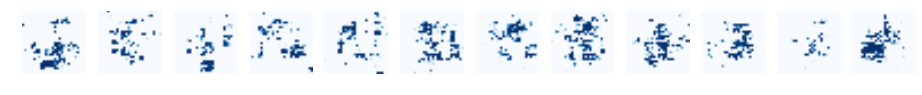

....................................................................................................
Epoch 85, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 33% / 0.69322, forged 18% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 85, batch 199 (41.6 seconds since last report)
DISCRIMINATOR: real 4% / 0.69322, forged 51% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 85, batch 299 (41.9 seconds since last report)
DISCRIMINATOR: real 15% / 0.69322, forged 31% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 85, batch 399 (41.8 seconds since last report)
DISCRIMINATOR: real 58% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
..................................................................

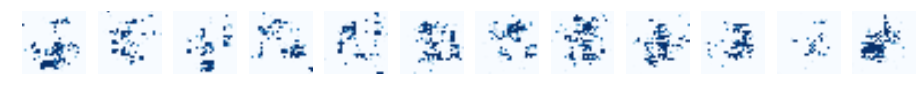

....................................................................................................
Epoch 86, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 22% / 0.69322, forged 31% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 86, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 6% / 0.69322, forged 42% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 86, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 22% / 0.69322, forged 34% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 86, batch 399 (41.6 seconds since last report)
DISCRIMINATOR: real 61% / 0.69322, forged 15% / 0.69322
GENERATOR: error = 0.69
..................................................................

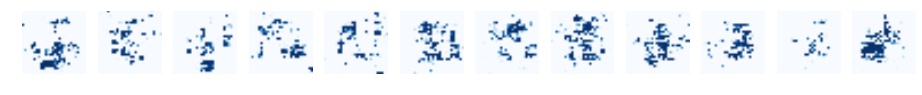

....................................................................................................
Epoch 87, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 88% / 0.69321
GENERATOR: error = 0.69
....................................................................................................
Epoch 87, batch 199 (42.0 seconds since last report)
DISCRIMINATOR: real 3% / 0.69322, forged 51% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 87, batch 299 (41.5 seconds since last report)
DISCRIMINATOR: real 1% / 0.69322, forged 61% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 87, batch 399 (42.7 seconds since last report)
DISCRIMINATOR: real 29% / 0.69322, forged 21% / 0.69322
GENERATOR: error = 0.69
....................................................................

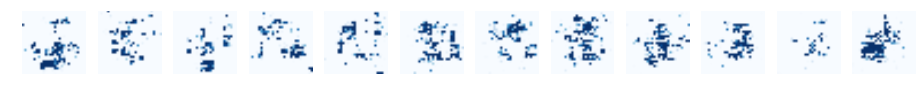

....................................................................................................
Epoch 88, batch 99 (42.3 seconds since last report)
DISCRIMINATOR: real 31% / 0.69322, forged 20% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 88, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 17% / 0.69322, forged 32% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 88, batch 299 (41.4 seconds since last report)
DISCRIMINATOR: real 22% / 0.69322, forged 18% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 88, batch 399 (41.6 seconds since last report)
DISCRIMINATOR: real 49% / 0.69322, forged 18% / 0.69322
GENERATOR: error = 0.69
.................................................................

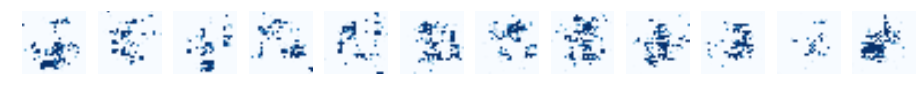

....................................................................................................
Epoch 89, batch 99 (42.3 seconds since last report)
DISCRIMINATOR: real 4% / 0.69322, forged 47% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 89, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 21% / 0.69322, forged 29% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 89, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 45% / 0.69322, forged 16% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 89, batch 399 (42.9 seconds since last report)
DISCRIMINATOR: real 50% / 0.69322, forged 19% / 0.69322
GENERATOR: error = 0.69
..................................................................

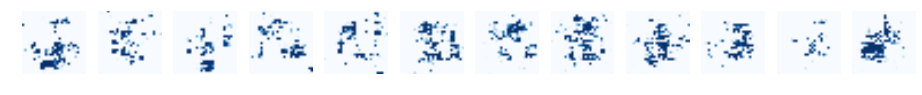

....................................................................................................
Epoch 90, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 43% / 0.69322, forged 9% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 90, batch 199 (41.6 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 69% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 90, batch 299 (41.5 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 87% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 90, batch 399 (41.6 seconds since last report)
DISCRIMINATOR: real 1% / 0.69322, forged 52% / 0.69322
GENERATOR: error = 0.69
.....................................................................

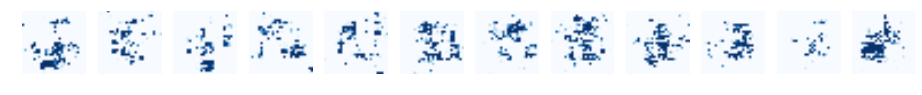

....................................................................................................
Epoch 91, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 59% / 0.69322, forged 10% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 91, batch 199 (41.7 seconds since last report)
DISCRIMINATOR: real 8% / 0.69322, forged 38% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 91, batch 299 (41.4 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 46% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 91, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 71% / 0.69322
GENERATOR: error = 0.69
....................................................................

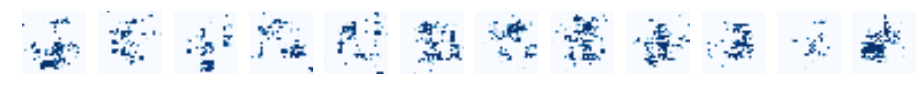

....................................................................................................
Epoch 92, batch 99 (42.5 seconds since last report)
DISCRIMINATOR: real 21% / 0.69322, forged 21% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 92, batch 199 (41.8 seconds since last report)
DISCRIMINATOR: real 24% / 0.69322, forged 18% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 92, batch 299 (41.4 seconds since last report)
DISCRIMINATOR: real 93% / 0.69322, forged 3% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 92, batch 399 (41.6 seconds since last report)
DISCRIMINATOR: real 53% / 0.69322, forged 7% / 0.69322
GENERATOR: error = 0.69
...................................................................

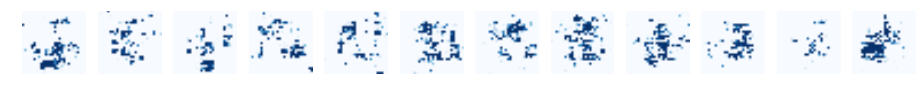

....................................................................................................
Epoch 93, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 52% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 93, batch 199 (42.3 seconds since last report)
DISCRIMINATOR: real 3% / 0.69322, forged 44% / 0.69321
GENERATOR: error = 0.69
....................................................................................................
Epoch 93, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 64% / 0.69322, forged 9% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 93, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 62% / 0.69322, forged 8% / 0.69322
GENERATOR: error = 0.69
.....................................................................

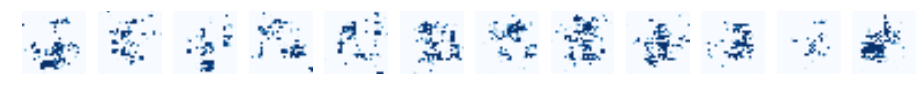

....................................................................................................
Epoch 94, batch 99 (42.6 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 35% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 94, batch 199 (41.3 seconds since last report)
DISCRIMINATOR: real 71% / 0.69322, forged 6% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 94, batch 299 (41.7 seconds since last report)
DISCRIMINATOR: real 11% / 0.69322, forged 44% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 94, batch 399 (42.9 seconds since last report)
DISCRIMINATOR: real 21% / 0.69322, forged 31% / 0.69322
GENERATOR: error = 0.69
...................................................................

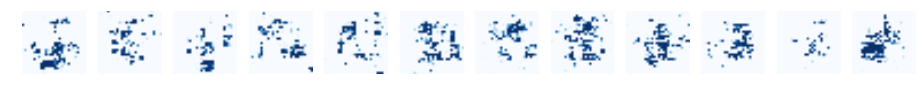

....................................................................................................
Epoch 95, batch 99 (42.2 seconds since last report)
DISCRIMINATOR: real 81% / 0.69322, forged 9% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 95, batch 199 (41.5 seconds since last report)
DISCRIMINATOR: real 29% / 0.69322, forged 23% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 95, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 37% / 0.69322, forged 24% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 95, batch 399 (41.4 seconds since last report)
DISCRIMINATOR: real 25% / 0.69322, forged 21% / 0.69322
GENERATOR: error = 0.69
..................................................................

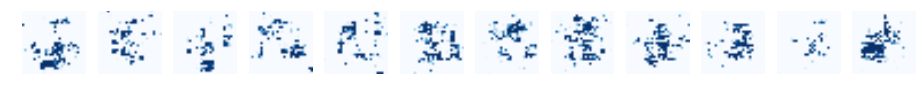

....................................................................................................
Epoch 96, batch 99 (42.3 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 68% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 96, batch 199 (41.6 seconds since last report)
DISCRIMINATOR: real 11% / 0.69322, forged 42% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 96, batch 299 (42.6 seconds since last report)
DISCRIMINATOR: real 21% / 0.69322, forged 36% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 96, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 7% / 0.69322, forged 45% / 0.69322
GENERATOR: error = 0.69
...................................................................

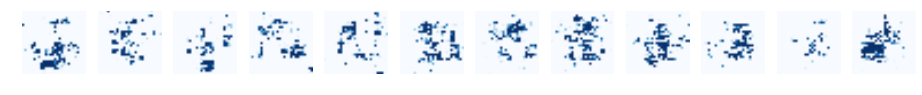

....................................................................................................
Epoch 97, batch 99 (42.4 seconds since last report)
DISCRIMINATOR: real 22% / 0.69322, forged 23% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 97, batch 199 (41.4 seconds since last report)
DISCRIMINATOR: real 52% / 0.69322, forged 13% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 97, batch 299 (41.5 seconds since last report)
DISCRIMINATOR: real 8% / 0.69322, forged 39% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 97, batch 399 (41.7 seconds since last report)
DISCRIMINATOR: real 8% / 0.69322, forged 38% / 0.69322
GENERATOR: error = 0.69
...................................................................

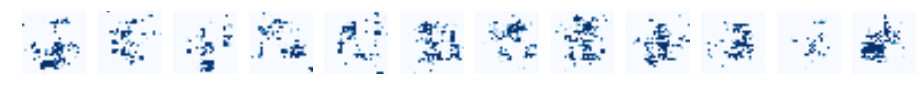

....................................................................................................
Epoch 98, batch 99 (42.1 seconds since last report)
DISCRIMINATOR: real 2% / 0.69322, forged 44% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 98, batch 199 (41.4 seconds since last report)
DISCRIMINATOR: real 20% / 0.69322, forged 21% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 98, batch 299 (41.6 seconds since last report)
DISCRIMINATOR: real 20% / 0.69322, forged 25% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 98, batch 399 (42.6 seconds since last report)
DISCRIMINATOR: real 92% / 0.69322, forged 8% / 0.69322
GENERATOR: error = 0.69
...................................................................

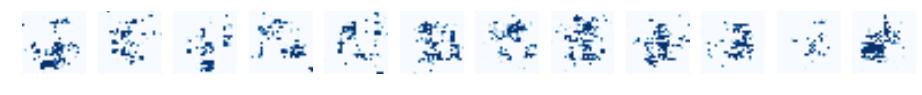

....................................................................................................
Epoch 99, batch 99 (42.7 seconds since last report)
DISCRIMINATOR: real 25% / 0.69322, forged 26% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 99, batch 199 (41.4 seconds since last report)
DISCRIMINATOR: real 0% / 0.69322, forged 65% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 99, batch 299 (41.5 seconds since last report)
DISCRIMINATOR: real 54% / 0.69322, forged 11% / 0.69322
GENERATOR: error = 0.69
....................................................................................................
Epoch 99, batch 399 (41.6 seconds since last report)
DISCRIMINATOR: real 8% / 0.69322, forged 31% / 0.69322
GENERATOR: error = 0.69
...................................................................

In [11]:
num_epochs = 100
batch_size = BATCH_SIZE
half_batch = batch_size / 2
disc_targets = np.concatenate((np.zeros(half_batch), np.ones(half_batch)))
validate_batch_size = BATCH_SIZE
validate_every_n_batches = 100
use_tensorboard = False

figsize(16, 1.5)

def Noise(*size):
    return np.random.uniform(-1, 1, size=size)

def PrepBatch(ims, start, stop):
    batch = ims[start:stop].reshape((stop - start,) + ims.shape[1:3] + (1,))
    return (batch / 127.5) - 1

batches_per_epoch = train_im.shape[0] / batch_size
mark = time.time()
train_gen = True
train_disc = True
reference_noise = Noise(batch_size, 100)
for ep in xrange(num_epochs):
    
    # Print generator outputs for reference noise vectors
    forgeries = G_image.eval(feed_dict={
        G_x: reference_noise})
    _, axes = plt.subplots(1, 12)
    for ax in xrange(12):
        axes[ax].axis("off")
        axes[ax].imshow(forgeries[ax], cmap=cm.Blues)
    plt.show()
    
    # Reorder the training set
    np.random.shuffle(train_im)

    for i in xrange(batches_per_epoch):
        sys.stdout.write(".")
        sys.stdout.flush()
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        batch_indices = np.arange(BATCH_SIZE)
        np.random.shuffle(batch_indices)

        # Train the discriminator
        forgeries = G_y.eval(feed_dict={
            G_x: Noise(batch_size, 100)})
        real = PrepBatch(train_im, start_offset, stop_offset)
        for j in xrange(2):
            half_start = j * half_batch
            half_stop = half_start + half_batch
            train_data = np.concatenate((
                forgeries[half_start:half_stop],
                real[half_start:half_stop]))
            D_train_step.run(feed_dict={
                D_x: train_data[batch_indices],
                D_y_: disc_targets[batch_indices],
                train_rate: 0.0005 / (ep + 1)})

        # Train the generator
        G_train_step.run(feed_dict={
            G_x: Noise(batch_size, 100),
            train_rate: 0.0005 / (ep + 1)})

        # Validation
        if (i + 1) % validate_every_n_batches == 0:
            
            # With Tensorboard, validate more often but print less.
            if use_tensorboard:
                forgeries = G_y.eval(feed_dict={
                    G_x: Noise(batch_size, 100)})
                real = PrepBatch(test_im, 0, half_batch)
                test_data = np.concatenate((forgeries[0:half_batch], real))
                summary_str, acc = sess.run(
                    [all_summaries, D_accuracy],
                    feed_dict={
                        D_x: test_data,
                        D_y_: disc_targets})
                writer.add_summary(
                    summary_str,
                    i + (batches_per_epoch * ep))
                print "Epoch {ep}, batch {ba}: accuracy = {ac}".format(
                    ep=ep, ba=i, ac=acc)

            # Without Tensorboard, validate less often but print more.
            else:
                ac_real, xent_real = sess.run(
                    [D_accuracy, D_xent], feed_dict={
                        D_x: PrepBatch(test_im, 0, validate_batch_size),
                        D_y_: np.ones(validate_batch_size)})
                
                ac_forged, xent_forged, ger = sess.run(
                    [D_accuracy, D_xent, G_err],
                    feed_dict={
                        G_x: Noise(validate_batch_size, 100),
                        D_y_: np.zeros(validate_batch_size)})
                print ("\nEpoch {ep}, batch {ba} ({t:.1f} seconds since last report)"
                       "\nDISCRIMINATOR: real {acr:.0f}% / {xr:.5f}, "
                       "forged {acf:.0f}% / {xf:.5f}"
                       "\nGENERATOR: error = {ger:.2f}").format(
                    ep=ep, ba=i, t=time.time() - mark,
                    acr=ac_real * 100, xr=xent_real, acf=ac_forged * 100, xf=xent_forged, ger=ger)
                mark = time.time()